# Model parameterization

---

Taken from the supplementary material of Cyril Pernet's article on GLM misconceptions

> **Misconceptions in the use of the General Linear Model applied to functional MRI: a tutorial for junior neuro-imagers.** Front. Neurosci., 21 January 2014, https://doi.org/10.3389/fnins.2014.00001

---

This Matlab code is a simple demonstration of how to code design
matrices for fMRI. For simplicity, no convolution is involved
(i.e. no model of the haemodynamic response function).
The principles developed however do apply to fMRI analyses.

Cyril Pernet

v1 - 5 April 2013 // v2 - 1 Octobre 2013 - added edits, comments etc ..

In [13]:
% when running localy
path_to_spm = '/home/remi/matlab/SPM/spm12/';
addpath(path_to_spm)

In [14]:
clear;

## Controlled block design

First create the data alternating:
- the control condition (baseline) set at 10, 
- with the experimental condition set at 11, ie. 10% change condition > baseline

In [15]:
baseline = [9.9 10 10.1];     % average 10
condition = [10.9 11 11.1];   % average 11
Y = [baseline condition baseline condition baseline condition]';

SStotal = norm(Y - mean(Y)).^2; % this is the total sum of squares

No matter the design matrix, each time we can solve the equation:

$Y = X*B + e$

by computing:

$B = X^+*Y$


The modelled data are thus:

$\hat{Y} = X*B$

and the residuals are:


$Res = Y-\hat{Y}$



### Consider a model where all events are modelled

Over parameterized model: activation versus 0 T=185.903 p=0 
Over parameterized model: activation versus beaeline T=24.4949 p=4.10783e-14 


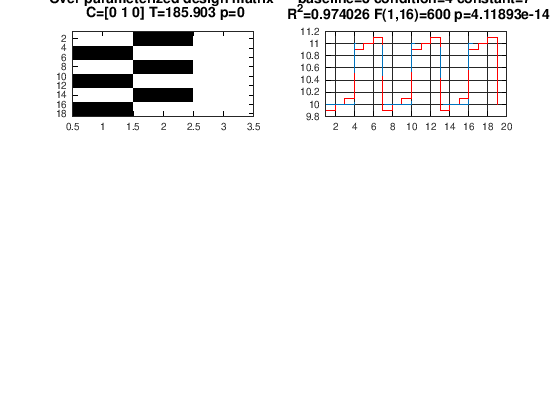

In [16]:
X1 = [repmat([kron(eye(2), ones(3, 1))], 3, 1) ones(18, 1)];
beta1 = pinv(X1) * Y;
Yhat = X1 * beta1;
Residuals = Y - Yhat;

% the model statistics are
SSeffect = norm(Yhat - mean(Yhat)).^2;          % sum of squares of the effect
SSerror = norm(Residuals - mean(Residuals)).^2; % sum of squares of the error
R2 = SSeffect / SStotal;                      % R square value (amount of variance explained)
df = rank(X1) - 1;                              % degrees of freedom of the model
dfe = length(Y) - rank(X1);                     % degrees of freedom of the error
F = (SSeffect / df) / (SSerror / dfe);            % F value
p_val = 1 - spm_Fcdf(F, df, dfe);                     % p value

%%
% the statistics for a given condition can be obtained using a contrast
% for a details on computations performed below see e.g. Human Brain Function book
% <http://www.fil.ion.ucl.ac.uk/spm/doc/books/hbf2/pdfs/Ch7.pdf>
% make a figure

figure('Name', 'Fig. 2 Controlled block design');

subplot(3, 2, 1);
imagesc(X1);
colormap('gray');

subplot(3, 2, 2);
stairs([1:19], [Y; 10], 'r', 'LineWidth', 3);
axis([1 20 9.8 11.2]);
hold on;
stairs([1:19], [Yhat; 11], '--', 'LineWidth', 3);
grid on;
mytitle = sprintf('baseline=%g condition=%g constant=%g \n R^2=%g F(%g,%g)=%g p=%g', beta1(1), beta1(2), beta1(3), R2, df, dfe, F, p_val);
title(mytitle, 'FontSize', 14);

P = X1 * pinv(X1);                                          % Projection matrix onto X
R = eye(size(Y, 1)) - P;                                   % Projection onto null space
variance = ((R * Y)' * (R * Y)) / (size(Y, 1) - rank(X1));
C = [0 1 0];                                              % contrast for condition
T_con = (C * beta1) ./ sqrt(variance .* (C * pinv(X1' * X1) * C')); % T value
p_con = 2 * (1 - spm_Tcdf(T_con, size(Y, 1) - rank(X1)));
fprintf('Over parameterized model: activation versus 0 T=%g p=%g \n', T_con, p_con);

% update figure
mytitle = sprintf('Over parameterized design matrix \n C=[0 1 0] T=%g p=%g', T_con, p_con);
subplot(3, 2, 1);
title(mytitle, 'FontSize', 14);

% However, when explicitely modelling baseline, one usually
% contrast activation versus rest
C = [-1 1 0]; % contrast for condition versus baseline
T_con = (C * beta1) ./ sqrt(variance .* (C * pinv(X1' * X1) * C'));
p_con = 2 * (1 - spm_Tcdf(T_con, size(Y, 1) - rank(X1)));
fprintf('Over parameterized model: activation versus beaeline T=%g p=%g \n', T_con, p_con);

### Consider a model where baseline is not modelled

Well parameterized model: activation versus implicit baseline T=24.4949 p=4.10783e-14 


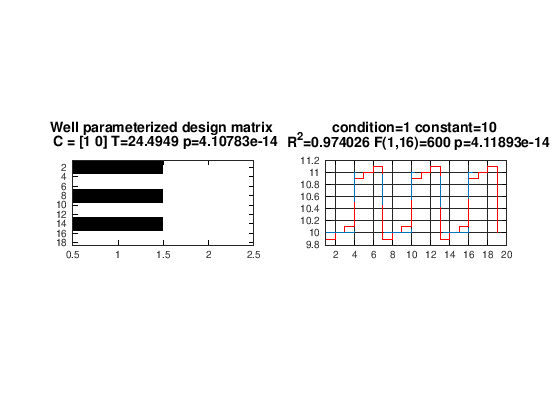

In [17]:
X2 = X1;
X2(:, 1) = [];
beta2 = pinv(X2) * Y;
Yhat = X2 * beta2;
Residuals = Y - Yhat;

subplot(3, 2, 3);
imagesc(X2);
colormap('gray');

subplot(3, 2, 4);
stairs([1:19], [Y; 10], 'r', 'LineWidth', 3);
axis([1 20 9.8 11.2]);
hold on;
stairs([1:19], [Yhat; 11], '--', 'LineWidth', 3);
grid on;

% stats 1
SSeffect = norm(Yhat - mean(Yhat)).^2;
SSerror = norm(Residuals - mean(Residuals)).^2;
R2 = SSeffect / SStotal;
df = rank(X2) - 1;
dfe = length(Y) - rank(X2);
F = (SSeffect / df) / (SSerror / dfe);
p_val = 1 - spm_Fcdf(F, df, dfe);
mytitle = sprintf('condition=%g constant=%g \n R^2=%g F(%g,%g)=%g p=%g', ...
                    beta2(1), beta2(2), R2, df, dfe, F, p_val);
title(mytitle, 'FontSize', 14);

% stats 2
P = X2 * pinv(X2); % H matrix
R = eye(size(Y, 1)) - P;
variance = ((R * Y)' * (R * Y)) / (size(Y, 1) - rank(X2));
C = [1 0]; % contrast for condition
T_con = (C * beta2) ./ sqrt(variance .* (C * pinv(X2' * X2) * C')); % T value
p_con = 2 * (1 - spm_Tcdf(T_con, size(Y, 1) - rank(X2)));
mytitle = sprintf('Well parameterized design matrix \n C = [1 0] T=%g p=%g', T_con, p_con);
subplot(3, 2, 3);
title(mytitle, 'FontSize', 14);
fprintf('Well parameterized model: activation versus implicit baseline T=%g p=%g \n', T_con, p_con);

% the constant term returns a value accounting for the presence of the
% other regressors thus in the 1st (overparameterized) model the constant is
% 7 so that constant+beta1 = baseline and constant+beta2 = condition.
% In the 2nd model, we only model the change (ie the condition) and the
% constant therefore reflects the mean value without this change ie 10
% while the condition regressor takes the value 1 (constant+beta1 =
% condition).


### Consider another model where the design matrix is not between 0 and 1 but between 0 and 2

Well parameterized model, design matrix scaled up: activation versus implicit baseline T=24.4949 p=4.10783e-14 


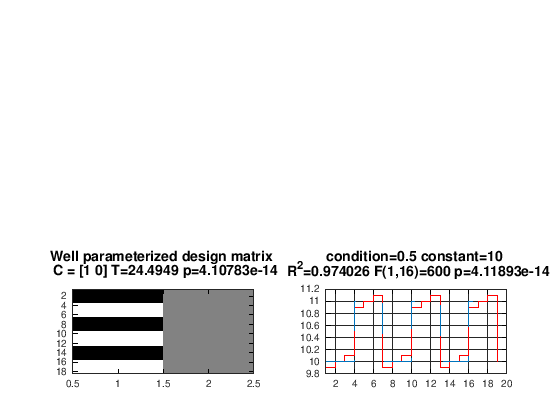

In [18]:
X3 = X2;
X3(find(X2(:, 1)), 1) = 2;
beta3 = pinv(X3) * Y;
Yhat = X3 * beta3;
Residuals = Y - Yhat;

subplot(3, 2, 5);
imagesc(X3);
colormap('gray');
subplot(3, 2, 6);
stairs([1:19], [Y; 10], 'r', 'LineWidth', 3);
axis([1 20 9.8 11.2]);
hold on;
stairs([1:19], [Yhat; 11], '--', 'LineWidth', 3);
grid on;

% stats 1
SSeffect = norm(Yhat - mean(Yhat)).^2;
SSerror = norm(Residuals - mean(Residuals)).^2;
R2 = SSeffect / SStotal;
df = rank(X3) - 1;
dfe = length(Y) - rank(X3);
F = (SSeffect / df) / (SSerror / dfe);
p_val = 1 - spm_Fcdf(F, df, dfe);
mytitle = sprintf('condition=%g constant=%g \n R^2=%g F(%g,%g)=%g p=%g', ...
                    beta3(1), beta3(2), R2, df, dfe, F, p_val);
title(mytitle, 'FontSize', 14);

% stats 2
P = X3 * pinv(X3); % H matrix
R = eye(size(Y, 1)) - P;
variance = ((R * Y)' * (R * Y)) / (size(Y, 1) - rank(X3));
C = [1 0]; % contrast for condition
T_con = (C * beta3) ./ sqrt(variance .* (C * pinv(X3' * X3) * C')); % T value
p_con = 2 * (1 - spm_Tcdf(T_con, size(Y, 1) - rank(X3)));
mytitle = sprintf('Well parameterized design matrix \n C = [1 0] T=%g p=%g', T_con, p_con);
subplot(3, 2, 5);
title(mytitle, 'FontSize', 14);
fprintf('Well parameterized model, design matrix scaled up: activation versus implicit baseline T=%g p=%g \n', T_con, p_con);

%% Alternating block design
% alternate 2 experimental conditions set at 9 and 11,
% ie. 10% change relative to baseline 10

clear;
condition1 = [8.9 9 9.1];
baseline = [9.9 10 10.1];
condition2 = [10.9 11 11.1];
Y = [condition1 baseline ...
     condition2 baseline ...
     condition1 baseline ...
     condition2 baseline ...
     condition1 baseline condition2]';
SStotal = norm(Y - mean(Y)).^2;


### Consider a model where all events are modelled

Over parameterized model: cond2 > cond1 T=49.5434 p=0 


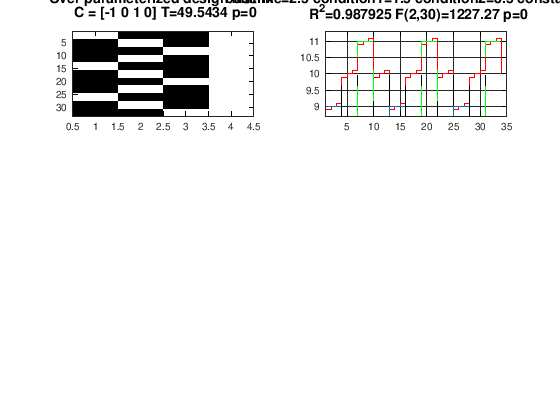

In [19]:
X1 = [[[kron(eye(3), ones(3, 1))]; [fliplr([kron(eye(2), ones(3, 1))]) zeros(6, 1)]; ...
       [zeros(6, 1) kron(eye(2), ones(3, 1))]; [zeros(3, 1) ones(3, 1) zeros(3, 1)]; ...
       [kron(eye(3), ones(3, 1))]] ones(33, 1)];
beta1 = pinv(X1) * Y;
Yhat = X1 * beta1;
Residuals = Y - Yhat;

figure('Name', 'Fig. 3 Alternating block design');

subplot(3, 2, 1);
imagesc(X1);
colormap('gray');
subplot(3, 2, 2);
stairs([1:34], [Y; 10], 'r', 'LineWidth', 3);
axis([1 35 8.7 11.3]);
yhat1 = X1(:, [1 4]) * beta1([1 4]);
hold on;
stairs([1:33], [yhat1], '--', 'LineWidth', 3);
yhat2 = X1(:, [2 4]) * beta1([2 4]);
stairs([1:33], [yhat2], 'k--', 'LineWidth', 3);
grid on;
yhat3 = X1(:, [3 4]) * beta1([3 4]);
stairs([1:34], [yhat3; 11], 'g--', 'LineWidth', 3);

% stats 1
SSeffect = norm(Yhat - mean(Yhat)).^2;
SSerror = norm(Residuals - mean(Residuals)).^2;
R2 = SSeffect / SStotal;
df = rank(X1) - 1;
dfe = length(Y) - rank(X1);
F = (SSeffect / df) / (SSerror / dfe);
p_val = 1 - spm_Fcdf(F, df, dfe);
mytitle = sprintf('baseline=%g condition1=%g condition2=%g constant=%g \n R^2=%g F(%g,%g)=%g p=%g', beta1(2), beta1(1), beta1(3), beta1(4), R2, df, dfe, F, p_val);
title(mytitle, 'FontSize', 14);

% stats 2
P = X1 * pinv(X1); % H matrix
R = eye(size(Y, 1)) - P;
variance = ((R * Y)' * (R * Y)) / (size(Y, 1) - rank(X1));
C = [-1 0 1 0]; % contrast for condition 2 > condition 1
T_con = (C * beta1) ./ sqrt(variance .* (C * pinv(X1' * X1) * C'));
p_con = 2 * (1 - spm_Tcdf(T_con, size(Y, 1) - rank(X1)));
mytitle = sprintf('Over parameterized design matrix \n C = [-1 0 1 0] T=%g p=%g', T_con, p_con);
subplot(3, 2, 1);
title(mytitle, 'FontSize', 14);
fprintf('Over parameterized model: cond2 > cond1 T=%g p=%g \n', T_con, p_con);

### Consider a model where baseline is not modelled

Well parameterized model: cond2 > cond1 T=49.5434 p=0 


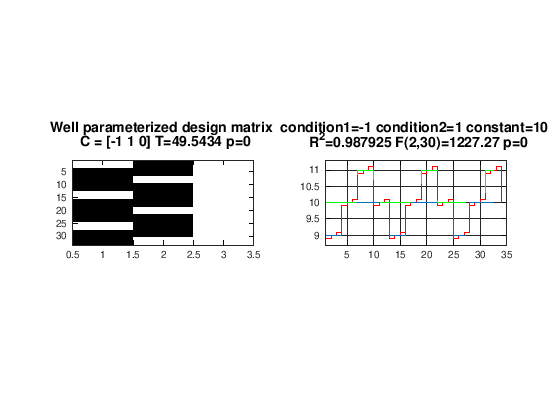

In [20]:
X2 = X1;
X2(:, 2) = [];
beta2 = pinv(X2) * Y;
Yhat = X2 * beta2;
Residuals = Y - Yhat;

subplot(3, 2, 3);
imagesc(X2);
colormap('gray');

subplot(3, 2, 4);
stairs([1:34], [Y; 10], 'r', 'LineWidth', 3);
axis([1 35 8.7 11.3]);
yhat1 = X2(:, [1 3]) * beta2([1 3]);
hold on;
stairs([1:34], [yhat1; 10], '--', 'LineWidth', 3);
yhat2 = X2(:, [2 3]) * beta2([2 3]);
stairs([1:34], [yhat2; 11], 'g--', 'LineWidth', 3);
grid on;

% stats 1
SSeffect = norm(Yhat - mean(Yhat)).^2;
SSerror = norm(Residuals - mean(Residuals)).^2;
R2 = SSeffect / SStotal;
df = rank(X1) - 1;
dfe = length(Y) - rank(X1);
F = (SSeffect / df) / (SSerror / dfe);
p_val = 1 - spm_Fcdf(F, df, dfe);
mytitle = sprintf('condition1=%g condition2=%g constant=%g \n R^2=%g F(%g,%g)=%g p=%g', beta2(1), beta2(2), beta2(3), R2, df, dfe, F, p_val);
title(mytitle, 'FontSize', 14);

% stats 2
P = X2 * pinv(X2); % H matrix
R = eye(size(Y, 1)) - P;
variance = ((R * Y)' * (R * Y)) / (size(Y, 1) - rank(X2));
C = [-1 1 0]; % contrast for condition
T_con = (C * beta2) ./ sqrt(variance .* (C * pinv(X2' * X2) * C'));
p_con = 2 * (1 - spm_Tcdf(T_con, size(Y, 1) - rank(X2)));
mytitle = sprintf('Well parameterized design matrix \n C = [-1 1 0] T=%g p=%g', T_con, p_con);
subplot(3, 2, 3);
title(mytitle, 'FontSize', 14);
fprintf('Well parameterized model: cond2 > cond1 T=%g p=%g \n', T_con, p_con);

### Consider another model where the design matrix is between 0 and 2

Well parameterized model, design matrix scaled up: cond2 > cond1 T=49.5434 p=0 


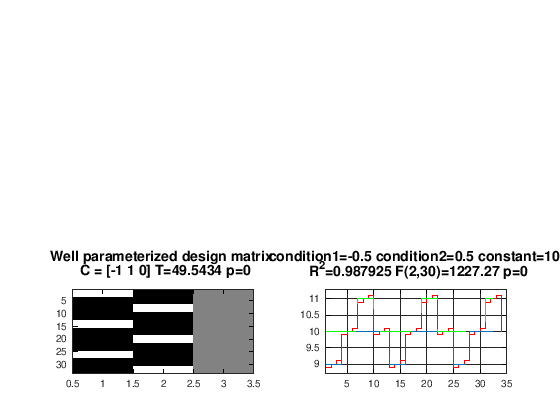

In [21]:
X3 = X2;
X3(find(X2(:, 1)), 1) = 2;
X3(find(X2(:, 2)), 2) = 2;
beta3 = pinv(X3) * Y;
Yhat = X3 * beta3;
Residuals = Y - Yhat;

subplot(3, 2, 5);
imagesc(X3);
colormap('gray');
subplot(3, 2, 6);
stairs([1:34], [Y; 10], 'r', 'LineWidth', 3);
axis([1 35 8.7 11.3]);
yhat1 = X3(:, [1 3]) * beta3([1 3]);
hold on;
stairs([1:34], [yhat1; 10], '--', 'LineWidth', 3);
yhat2 = X3(:, [2 3]) * beta3([2 3]);
stairs([1:34], [yhat2; 11], 'g--', 'LineWidth', 3);
grid on;

% stats 1
SSeffect = norm(Yhat - mean(Yhat)).^2;
SSerror = norm(Residuals - mean(Residuals)).^2;
R2 = SSeffect / SStotal;
df = rank(X3) - 1;
dfe = length(Y) - rank(X3);
F = (SSeffect / df) / (SSerror / dfe);
p_val = 1 - spm_Fcdf(F, df, dfe);
mytitle = sprintf('condition1=%g condition2=%g constant=%g \n R^2=%g F(%g,%g)=%g p=%g', beta3(1), beta3(2), beta3(3), R2, df, dfe, F, p_val);
title(mytitle, 'FontSize', 14);

% stats 2
P = X3 * pinv(X3); % H matrix
R = eye(size(Y, 1)) - P;
variance = ((R * Y)' * (R * Y)) / (size(Y, 1) - rank(X3));
C = [-1 1 0]; % contrast for condition
T_con = (C * beta3) ./ sqrt(variance .* (C * pinv(X3' * X3) * C'));
p_con = 2 * (1 - spm_Tcdf(T_con, size(Y, 1) - rank(X3)));
mytitle = sprintf('Well parameterized design matrix \n C = [-1 1 0] T=%g p=%g', T_con, p_con);
subplot(3, 2, 5);
title(mytitle, 'FontSize', 14);
fprintf('Well parameterized model, design matrix scaled up: cond2 > cond1 T=%g p=%g \n', T_con, p_con);

%% Alternating block design with no baseline
clear;
condition1 = [8.9 9 9.1];
condition2 = [10.9 11 11.1];
Y = [condition1 condition2 condition1 condition2 condition1 condition2]';
SStotal = norm(Y - mean(Y)).^2;



### The design has no baseline

Well parameterized model (no baseline in the design): cond2 > cond1 T=48.9898 p=0 


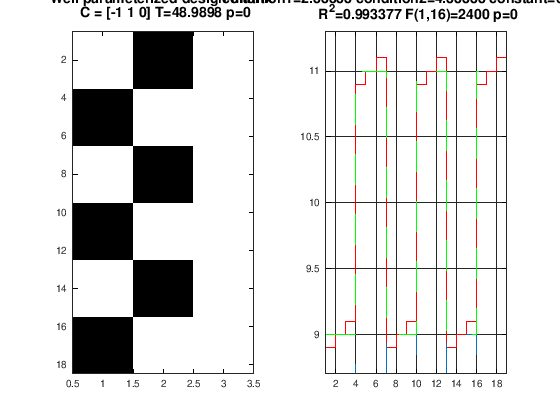

In [22]:
X1 = [repmat([kron(eye(2), ones(3, 1))], 3, 1) ones(18, 1)];
beta1 = pinv(X1) * Y;
yhat = X1 * beta1;
Residuals = Y - yhat;

figure('Name', 'Alternating block design with no baseline');
subplot(1, 2, 1);
imagesc(X1);
colormap('gray');
subplot(1, 2, 2);
stairs([1:19], [Y; 10], 'r', 'LineWidth', 3);
axis([1 19 8.7 11.3]);
yhat1 = X1(:, [1 3]) * beta1([1 3]);
hold on;
stairs([1:19], [yhat1; 10], '--', 'LineWidth', 3);
yhat2 = X1(:, [2 3]) * beta1([2 3]);
stairs([1:19], [yhat; 11], 'g--', 'LineWidth', 3);
grid on;

% stats 1
SSeffect = norm(yhat - mean(yhat)).^2;
SSerror = norm(Residuals - mean(Residuals)).^2;
R2 = SSeffect / SStotal;
df = rank(X1) - 1;
dfe = length(Y) - rank(X1);
F = (SSeffect / df) / (SSerror / dfe);
p_val = 1 - spm_Fcdf(F, df, dfe);
mytitle = sprintf('condition1=%g condition2=%g constant=%g \n R^2=%g F(%g,%g)=%g p=%g', beta1(1), beta1(2), beta1(3), R2, df, dfe, F, p_val);
title(mytitle, 'FontSize', 14);

% stats 2
P = X1 * pinv(X1); % H matrix
R = eye(size(Y, 1)) - P;
variance = ((R * Y)' * (R * Y)) / (size(Y, 1) - rank(X1));
C = [-1 1 0]; % contrast for condition
T_con = (C * beta1) ./ sqrt(variance .* (C * pinv(X1' * X1) * C'));
p_con = 2 * (1 - spm_Tcdf(T_con, size(Y, 1) - rank(X1)));
mytitle = sprintf('Well parameterized design matrix \n C = [-1 1 0] T=%g p=%g', T_con, p_con);
subplot(1, 2, 1);
title(mytitle, 'FontSize', 14);
fprintf('Well parameterized model (no baseline in the design): cond2 > cond1 T=%g p=%g \n', T_con, p_con);
